# 1) Imports and Parameters

In [1]:
!pip install -q tensorflow==1.15.2

In [2]:
#Imports
import os
import sys
import inspect
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mat
from datetime import datetime
from tensorflow.python.framework import ops
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import sklearn as sk
from modules import aux_functions #aux_functions .py file on modules folder
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\bcpython\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()

In [4]:
#Creating flags with the paths
FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_string('data_dir', 'dataset/', 'Path to the directory with train and test data')
tf.flags.DEFINE_string('logs_dir', 'model/', 'Path to the directory where the model will be saved')
tf.flags.DEFINE_string('mode', 'train', 'mode: train (Default) / test')

In [5]:
#Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
MAX_ITERATIONS = 1500
REGULARIZATION = 1e-3
IMAGE_SIZE = 48
NUM_LABELS = 7
VALIDATION_PERCENT = 0.1

# 2) Building the model

In [6]:
def emotionCNN(dataset):
    
    #Convolution layer 1
    with tf.name_scope('conv1') as scope:
        tf.summary.histogram('W_conv1', weights['wc1'])
        tf.summary.histogram('b_conv1', biases['bc1'])
        conv_1 = tf.nn.conv2d(dataset, weights['wc1'], strides = [1,1,1,1], padding = 'SAME')
        h_conv1 = tf.nn.bias_add(conv_1, biases['bc1'])
        h_1 = tf.nn.relu(h_conv1)
        h_pool1 = tf.nn.max_pool(h_1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME') #2x2 max pooling
        aux_functions.add_to_regularization_loss(weights['wc1'], biases['bc1'])
        
    #Convolution layer 2
    with tf.name_scope('conv2') as scope:
        tf.summary.histogram('W_conv2', weights['wc2'])
        tf.summary.histogram('b_conv2', biases['bc2'])
        conv_2 = tf.nn.conv2d(h_pool1, weights['wc2'], strides = [1,1,1,1], padding = 'SAME')
        h_conv2 = tf.nn.bias_add(conv_2, biases['bc2'])
        h_2 = tf.nn.relu(h_conv2)
        h_pool2 = tf.nn.max_pool(h_2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME') #2x2 max pooling
        aux_functions.add_to_regularization_loss(weights['wc2'], biases['bc2'])
        
    #Fully connected layer 1
    with tf.name_scope('fc_1') as scope:
        prob = 0.5
        image_size = int(IMAGE_SIZE/4) #we need to match the max pooling shapes
        h_flat = tf.reshape(h_pool2, [-1, image_size * image_size * 64])
        tf.summary.histogram('W_conv1', weights['wf1'])
        tf.summary.histogram('b_conv1', biases['bf1'])
        h_fc1 = tf.nn.relu(tf.matmul(h_flat, weights['wf1']) + biases['bf1'])
        h_fc1_dropout = tf.nn.dropout(h_fc1, prob)
        
    #Fully connected layer 2
    with tf.name_scope('fc_2') as scope:
        tf.summary.histogram('W_fc2', weights['wf2'])
        tf.summary.histogram('b_fc2', biases['bf2'])
        pred = tf.matmul(h_fc1_dropout, weights['wf2'] + biases['bf2'])
            
    return pred            

In [7]:
#Weights and biases

weights = {
    'wc1': aux_functions.weight_variable([5,5,1,32], name = 'W_conv1'),
    'wc2': aux_functions.weight_variable([3,3,32,64], name = 'W_conv2'),
    'wf1': aux_functions.weight_variable([int((IMAGE_SIZE/4)*(IMAGE_SIZE/4)) * 64, 256], name = 'W_fc1'),
    'wf2': aux_functions.weight_variable([256, NUM_LABELS], name = 'W_fc2')    
}

biases = {
    'bc1': aux_functions.bias_variable([32], name = 'b_conv1'),
    'bc2': aux_functions.bias_variable([64], name = 'b_conv2'),
    'bf1': aux_functions.bias_variable([256], name = 'b_fc1'),
    'bf2': aux_functions.bias_variable([NUM_LABELS], name = 'b_fc2')    
}

In [8]:
def loss(pred,label):
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = label))
    tf.summary.scalar('Entropy', cross_entropy_loss)
    reg_losses = tf.add_n(tf.get_collection('losses'))
    tf.summary.scalar('Reg_loss', reg_losses)
    return cross_entropy_loss + REGULARIZATION * reg_losses

In [9]:
def train (loss, step):
    return tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss, global_step=step)

In [10]:
def get_next_batch(images, labels, step):
    offset = (step * BATCH_SIZE) % (images.shape[0] - BATCH_SIZE)
    batch_images = images[offset: offset + BATCH_SIZE]
    batch_labels = labels[offset: offset + BATCH_SIZE]
    return batch_images,batch_labels

In [11]:
#Lists for train results
train_error_list = []
train_step_list = []

#Lists for validation resuts
valid_error_list = []
valid_step_list = []

# 3)Training the model

In [12]:
sys.argv = sys.argv[:1] #to avoid Unrecognized Flag Error

def main(argv = None):
   #Load data
    train_images, train_labels, validation_images, validation_labels, test_images = aux_functions.read_data(FLAGS.data_dir)
    
    print("Size of the train dataset: %s" % train_images.shape[0])
    print('Size of the validation dataset: %s' % validation_images.shape[0])
    print("Size of the test dataset: %s" % test_images.shape[0])

    global_step = tf.Variable(0, trainable = False)
    dropout_prob = tf.placeholder(tf.float32)
    input_dataset = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 1], name = 'input')
    input_labels = tf.placeholder(tf.float32, [None, NUM_LABELS])
    
    pred = emotionCNN(input_dataset)
    output_pred = tf.nn.softmax(pred, name = 'output')
    loss_val = loss(pred, input_labels)
    train_op = train (loss_val,global_step)
    
    summary_op = tf.summary.merge_all()
    init_op = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init_op)
        summary_writer = tf.summary.FileWriter(FLAGS.logs_dir, sess.graph)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(FLAGS.logs_dir)
        
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('Model restored.')
            
        for step in range(MAX_ITERATIONS):
            batch_image, batch_label = get_next_batch(train_images, train_labels, step)
            feed_dict = {input_dataset:batch_image,
                        input_labels:batch_label}
            sess.run(train_op, feed_dict = feed_dict)
            #showing the train loss every 10 iterations 
            if step % 10 == 0:
                train_loss, summary_str = sess.run([loss_val, summary_op], feed_dict = feed_dict)
                summary_writer.add_summary(summary_str, global_step = step)
                train_error_list.append(train_loss)
                train_step_list.append(step)
                print(f'Train Loss: {train_loss}')
            #showing the validation loss every 100 iterations
            if step % 100 == 0:
                valid_loss = sess.run(loss_val, feed_dict = {input_dataset:validation_images,
                                                            input_labels:validation_labels})
                valid_error_list.append(valid_loss)
                valid_step_list.append(step)                
                print(f'\nLoss on the validation: {datetime.now()} -> {valid_loss}')
                saver.save(sess,FLAGS.logs_dir + 'model.ckpt', global_step = step)
            
            
        #Plotting the error per iteration during train   
        plt.plot(train_step_list, train_error_list, 'r--', label = 'Loss in train per iteration', linewidth = 3)
        plt.title('Loss in train per iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Loss in train')
        plt.ylim(0,2)
        plt.legend()
        plt.grid()
        plt.show()
        
        #Plotting the error per iteration during validation
        plt.plot(valid_step_list, valid_error_list, 'r--', label = 'Loss in validation per iteration', linewidth = 3, color = 'g')
        plt.title('Loss in validation per iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Loss in validation')
        plt.ylim(0,2)
        plt.legend()
        plt.grid()
        plt.show()

Size of the train dataset: 3761
Size of the validation dataset: 417
Size of the test dataset: 1312



W0329 22:02:01.300361 13144 module_wrapper.py:139] From C:\Users\bcpython\Documents\Python Projects\DeepLearning - Detecting Emotions in Pictures with Convolutional Neural Network\modules\aux_functions.py:131: The name tf.add_to_collection is deprecated. Please use tf.compat.v1.add_to_collection instead.



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0329 22:02:01.319267 13144 deprecation.py:506] From <ipython-input-6-28159a80c2ca>:31: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



W0329 22:02:01.343208 13144 deprecation.py:323] From <ipython-input-8-cd609b667279>:2: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Train Loss: 39.9744987487793

Loss on the validation: 2021-03-29 22:02:03.780024 -> 40.57190704345703
Train Loss: 8.299312591552734
Train Loss: 2.2589621543884277
Train Loss: 2.1537864208221436
Train Loss: 2.2462689876556396
Train Loss: 2.0611279010772705
Train Loss: 2.0567362308502197
Train Loss: 1.9881174564361572
Train Loss: 1.9499032497406006
Train Loss: 1.8642467260360718
Train Loss: 1.8182673454284668

Loss on the validation: 2021-03-29 22:02:43.037130 -> 1.8856226205825806
Train Loss: 1.8582026958465576
Train Loss: 1.7362037897109985
Train Loss: 1.6715651750564575
Train Loss: 1.7438290119171143
Train Loss: 1.7507463693618774
Train Loss: 1.794887661933899
Train Loss: 1.7130192518234253
Train Loss: 1.6614620685577393
Train Loss: 1.5300894975662231
Train Loss: 1.574946641921997

Loss on the validation: 2021-03-29 22:03:23.424549 -> 1.7011215686798096
Train Loss: 1.7051379680633545
Train Loss: 1.5353270769119263
Train Loss: 1.5170799493789673
Train Loss: 1.4983556270599365
Train Los

W0329 22:05:26.151451 13144 deprecation.py:323] From C:\Users\bcpython\anaconda3\lib\site-packages\tensorflow_core\python\training\saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Train Loss: 1.005903720855713
Train Loss: 1.1004211902618408
Train Loss: 1.1235159635543823
Train Loss: 0.9491124153137207
Train Loss: 1.0357106924057007
Train Loss: 1.0841166973114014
Train Loss: 1.031748652458191
Train Loss: 1.037313461303711
Train Loss: 0.9676849246025085
Train Loss: 0.9917436838150024

Loss on the validation: 2021-03-29 22:06:04.667115 -> 1.197448968887329
Train Loss: 0.8776110410690308
Train Loss: 1.1477985382080078
Train Loss: 1.0485079288482666
Train Loss: 1.1202008724212646
Train Loss: 0.8702567219734192
Train Loss: 0.9027022123336792
Train Loss: 0.8453480005264282
Train Loss: 0.8376469612121582
Train Loss: 0.9547092914581299
Train Loss: 0.9970430135726929

Loss on the validation: 2021-03-29 22:06:42.099036 -> 1.2507413625717163
Train Loss: 0.9429769515991211
Train Loss: 0.9395319223403931
Train Loss: 0.8899175524711609
Train Loss: 1.049511194229126
Train Loss: 0.9476929903030396
Train Loss: 0.8577472567558289
Train Loss: 0.8734753727912903
Train Loss: 0.802934

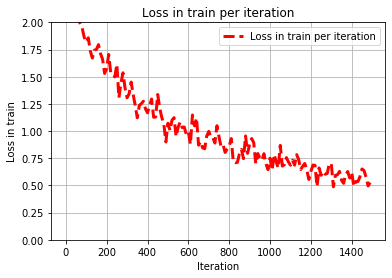

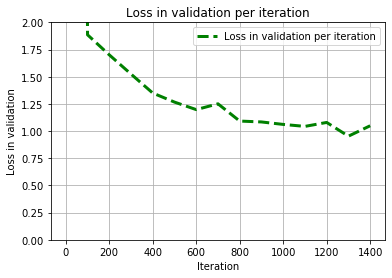

SystemExit: 

In [13]:
#Running the model
if __name__ == "__main__":
    tf.app.run()